<a href="https://colab.research.google.com/github/victorbarthvby/Machinelearning_project_A4/blob/main/1RenduML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!jupyter nbconvert --to html /content/1RenduML.ipynb

[NbConvertApp] Converting notebook /content/1RenduML.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 454263 bytes to /content/1RenduML.html


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from google.colab import drive
csv_path = "/content/drive/MyDrive/DataCoSupplyChainDataset.csv"
pd.set_option("display.max_columns", 120)


# Descriptive Analysis

In [ ]:
#create the dataset from data
for enc in ["utf-8", "utf-8-sig", "latin-1", "cp1252"]:
    try:
        df = pd.read_csv(csv_path, encoding=enc, low_memory=False)
        print(f"Loaded with encoding: {enc} | shape: {df.shape}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

Loaded with encoding: latin-1 | shape: (180519, 53)


In [ ]:
#Observe the basic construction of the dataset
print("Shape:", df.shape)
display(df.head(3))

dtypes = df.dtypes.astype(str).reset_index()
dtypes.columns = ["column", "dtype"]
display(dtypes.head(20))

missing = (df.isna().mean()*100).round(2).sort_values(ascending=False).reset_index()
missing.columns = ["column","missing_%"]
display(missing.head(20))

Shape: (180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


,column,dtype
0,Type,object
1,Days for shipping (real),int64
2,Days for shipment (scheduled),int64
3,Benefit per order,float64
4,Sales per customer,float64
5,Delivery Status,object
6,Late_delivery_risk,int64
7,Category Id,int64
8,Category Name,object
9,Customer City,object


,column,missing_%
0,Product Description,100.00
1,Order Zipcode,86.24
2,Days for shipment (scheduled),0.00
3,Days for shipping (real),0.00
4,Type,0.00
5,Delivery Status,0.00
6,Late_delivery_risk,0.00
7,Category Id,0.00
8,Category Name,0.00
9,Customer City,0.00


In [ ]:
#delete non interesting data (first cut we may delete other after)
cols_to_drop = [
    "Product Status","Product Image","Product Description","Customer Email",
    "Customer Fname", "Customer Lname","Customer Password",
]

cols_to_drop = [c for c in cols_to_drop if c in df.columns]  # make sure every column exist
df = df.drop(columns=cols_to_drop)
print("Dropped:", cols_to_drop)
print("New shape:", df.shape)
#df.to_csv("DataCo_clean.csv", index=False) if we need to save the clean data

Dropped: ['Product Status', 'Product Image', 'Product Description', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password']
New shape: (180519, 46)


count    180519.000000
mean          3.497654
std           1.623722
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
90%           6.000000
95%           6.000000
99%           6.000000
max           6.000000
Name: Days for shipping (real), dtype: float64
Skewness: 0.08477127299528447


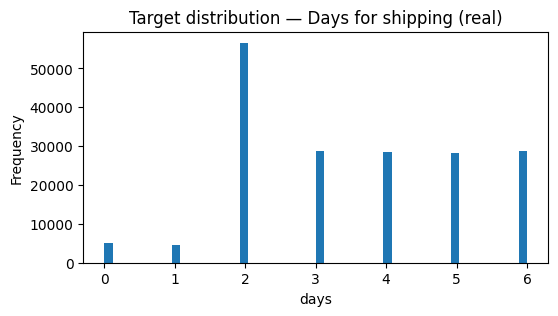

In [ ]:
# convert date column
date_cols = [c for c in df.columns if "date" in c.lower()]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# identified key column
target_col    = "Days for shipping (real)"
scheduled_col = "Days for shipment (scheduled)"

# analyse the target column (futur prediction)
y = df[target_col].dropna()
print(y.describe(percentiles=[.25,.5,.75,.9,.95,.99]))
print("Skewness:", y.skew())

plt.figure(figsize=(6,3))
y.plot(kind="hist", bins=50)
plt.title(f"Target distribution — {target_col}")
plt.xlabel("days"); plt.show()


What we observe (target = Days for shipping (real))

Range: 0 to 6 (hard cap at 6).

Center: mean 3.50, median 3.00 → close together.

Spread: std 1.62, IQR [2, 5].

Skewness: 0.085 → essentially symmetric.

Upper mass: P90=P95=P99=6 → many orders hit the ceiling.

In [ ]:
def show_cat(c, top=10):
    if c in df.columns:
        print(f"\n== {c} ==")
        display((df[c].value_counts(dropna=False, normalize=True)*100).round(2).head(top))

for c in ["Shipping Mode", "Product Category", "Department Name", "Customer Country", "Delivery Status", "Type"]:
    show_cat(c)

# late order for the report
if scheduled_col in df.columns:
    df["is_late"] = (df[target_col] > df[scheduled_col]).astype(int)
    print("\nLate rate (derived):")
    print((df["is_late"].value_counts(normalize=True)*100).round(2))



== Shipping Mode ==


,proportion
Shipping Mode,
Standard Class,59.69
Second Class,19.51
First Class,15.41
Same Day,5.39



== Department Name ==


,proportion
Department Name,
Fan Shop,37.04
Apparel,27.14
Golf,18.40
Footwear,8.05
Outdoors,5.37
Fitness,1.37
Discs Shop,1.12
Technology,0.81
Pet Shop,0.27



== Customer Country ==


,proportion
Customer Country,
EE. UU.,61.57
Puerto Rico,38.43



== Delivery Status ==


,proportion
Delivery Status,
Late delivery,54.83
Advance shipping,23.04
Shipping on time,17.84
Shipping canceled,4.30



== Type ==


,proportion
Type,
DEBIT,38.39
TRANSFER,27.63
PAYMENT,23.11
CASH,10.87



Late rate (derived):
is_late
1    57.28
0    42.72
Name: proportion, dtype: float64


We examine the class distribution to identify any imbalance. The classes appear broadly balanced, but we’ll keep these ratios in mind during modeling and evaluation.

In [ ]:
# exlude potential leakage column
leak_patterns = ["is_late",
        "Late_delivery_risk",
        "Delivery Status",
        "Days for shipping (real)",
        "Days for shipment (difference)",
        "Shipping Date (Actual)",
        "Delivery Date",
]
def is_leak(c):
    return any(re.search(p, c, flags=re.IGNORECASE) for p in leak_patterns)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target_col and not is_leak(c)]

corr_s = df[num_cols + [target_col]].corr(method="spearman")[target_col].drop(target_col).sort_values(ascending=False)
print("Top absolute correlations:\n")
display(corr_s.abs().sort_values(ascending=False).head(20))


Top absolute correlations:



,Days for shipping (real)
Days for shipment (scheduled),0.500262
Customer Id,0.003778
Order Customer Id,0.003778
Order Item Profit Ratio,0.002857
Benefit per order,0.002671
Order Profit Per Order,0.002671
Latitude,0.002527
Order Zipcode,0.002487
Order Id,0.002314
Order Item Id,0.002314


As expected, the scheduling variable is correlated and should be useful for modeling.

# Pre-proccesing

In [ ]:
# delete leakage column
leak_cols = [c for c in df.columns if is_leak(c)]

id_cols = [c for c in df.columns if re.search(r"\b(id|code)\b", c, flags=re.IGNORECASE)]
# On garde 'Order Id' pour split groupé ; 'Order Item Id' est la clé primaire (grain ligne)
keep_for_group = ["Order Id", "Order Item Id"]
id_cols_for_features = [c for c in id_cols if c not in keep_for_group]

print("Leak cols:", leak_cols)
print("ID (drop-as-features) cols:", id_cols_for_features)


Leak cols: ['Delivery Status', 'Late_delivery_risk', 'is_late']
ID (drop-as-features) cols: ['Category Id', 'Customer Id', 'Department Id', 'Order Customer Id', 'Order Item Cardprod Id', 'Product Card Id', 'Product Category Id']


In [ ]:
base_exclude = set(leak_cols + [target_col] + id_cols_for_features)

X = df.drop(columns=[c for c in base_exclude if c in df.columns])

# difference between num/cat
date_cols = [c for c in X.columns if "date" in c.lower()]
X_wo_dates = X.drop(columns=[c for c in date_cols if c in X.columns], errors="ignore")

num_features = X_wo_dates.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_wo_dates.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))


Numeric features: 18
Categorical features: 16


We split features into numerical and categorical types so we can apply appropriate preprocessing to each.


In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01)

num_tr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tr = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

# Forcer une sortie dense pour HistGradientBoostingRegressor
preproc = ColumnTransformer([
    ("num", num_tr, num_features),
    ("cat", cat_tr, cat_features)
], sparse_threshold=0.0)

# Formalisation of the problem

We address a supervised regression problem: predict the real shipping time (in days), noted y=Days for shipping (real), from information available at scheduling time (order, product, customer attributes, scheduled days, shipping mode, calendar features, etc.).
Leakage-prone variables (e.g., Delivery Status, Late_delivery_risk, any “actual/difference/real” fields) are excluded from training.
Evaluation relies on MAE (primary, interpretable in days) and RMSE (penalizes large errors). To avoid information leakage across order lines, we use a group-aware split with groups defined by Order Id (or a temporal split if required by the business process).

# Selection of a baseline model and implementation

In [ ]:
# Dataset features/target
feature_cols = [c for c in X_wo_dates.columns]
X_all = X_wo_dates[feature_cols].copy()
y_all = df[target_col].copy()

groups = df["Order Id"]  # important cause there is multiple line by order

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_all, groups))

X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all.iloc[train_idx], y_all.iloc[test_idx]

print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (144650, 34) (35869, 34)


In [ ]:
model = HistGradientBoostingRegressor(
    learning_rate=0.06, max_iter=1000,
    max_leaf_nodes=31, min_samples_leaf=100,
    l2_regularization=0.1,
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=20,
    random_state=42
)

pipe = Pipeline([
    ("prep", preproc),
    ("model", model)
])

# Fit & predict
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

# delete potential Nan
mask = ~np.isnan(y_test.values) & ~np.isnan(pred)
y_true_eval = y_test.values[mask]
y_pred_eval = pred[mask]

mae  = mean_absolute_error(y_true_eval, y_pred_eval)

mse  = mean_squared_error(y_true_eval, y_pred_eval)
rmse = float(np.sqrt(mse))

print(f"ML baseline — MAE: {mae:.3f} days | RMSE: {rmse:.3f} days")

ML baseline — MAE: 1.032 days | RMSE: 1.293 days


The model’s prediction of real shipping time is, on average, ~1.03 day away from the actual value; large errors are moderate (RMSE 1.29).

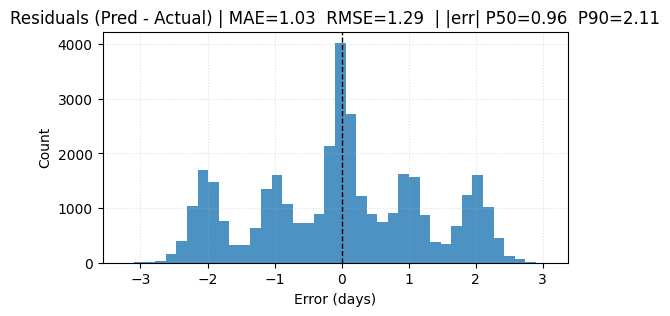

In [ ]:
res = y_pred_eval - y_true_eval
mae  = mean_absolute_error(y_true_eval, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
p50  = np.percentile(np.abs(res), 50)
p90  = np.percentile(np.abs(res), 90)

plt.figure(figsize=(6,3))
plt.hist(res, bins=40, alpha=0.8)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title(f"Residuals (Pred - Actual) | MAE={mae:.2f}  RMSE={rmse:.2f}  | |err| P50={p50:.2f}  P90={p90:.2f}")
plt.xlabel("Error (days)")
plt.ylabel("Count")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

What the plot shows

Centered near 0 (dashed line): no obvious global bias (model is not systematically over- or under-predicting).

MAE = 1.03 d, RMSE = 1.29 d: large errors exist but are not dominant (RMSE only slightly > MAE).

Discrete “bands” around ±1, ±2 days: consistent with a bounded/discrete target (0–6 days) → residuals cluster near integers.

Interpretation

The model is well-calibrated on average (residuals symmetric around 0).

Error spread is operationally acceptable for a first baseline: many orders are predicted within a 1-day window; only ~10% exceed ~2 days error.

Side peaks likely come from rounding/discreteness and segment effects

Confusion matrix (rows=true, cols=pred):
 [[ 6499  8717]
 [ 4428 16225]]

Classification report:
               precision    recall  f1-score   support

     On-time       0.59      0.43      0.50     15216
        Late       0.65      0.79      0.71     20653

    accuracy                           0.63     35869
   macro avg       0.62      0.61      0.60     35869
weighted avg       0.63      0.63      0.62     35869



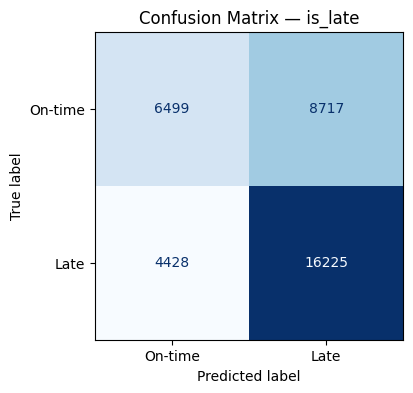

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# vérités terrain (alignées sur ton X_test)
y_true = y_true_eval
y_pred = y_pred_eval
scheduled_test = df.loc[X_test.index, "Days for shipment (scheduled)"].to_numpy()

is_late_true = (y_true > scheduled_test).astype(int)
is_late_pred = (y_pred > scheduled_test).astype(int)

cm = confusion_matrix(is_late_true, is_late_pred, labels=[0,1])
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n", classification_report(is_late_true, is_late_pred, target_names=["On-time","Late"]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-time","Late"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — is_late")
plt.show()


Key metrics (Late is the positive class):

Precision(Late) = 16 225 / (16 225 + 8 717) ≈ 0.65 → ~35% of “late” alerts are false.

Recall(Late) = 16 225 / 20 653 ≈ 0.79 → you catch most late orders.

Recall(On-time) (specificity) = 6 499 / 15 216 ≈ 0.43 → many on-time orders are flagged late.

FPR = 8 717 / 15 216 ≈ 0.57 (high) · FNR = 4 428 / 20 653 ≈ 0.21

Accuracy ≈ 0.63 · Macro-F1 ≈ 0.60 (imbalanced performance).

The system is recall-oriented for late detection (good at catching lates) but produces many false late alerts.

If missed delays are very costly, this operating point is acceptable; otherwise, you likely want fewer false alarms.